# Maximum load vs. 2 $\times$ load at maximum power

In [1]:
import sys as sys
import glob
import os as os
import re as re
import pandas as pd
import matplotlib as mpl
import multiprocessing as multiprocessing
import datetime as dt
from distutils import ccompiler

from simulation import *
from aesthetics import *
from plot import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

# The exact `matplotlib` version seems to have some minor effect on how many ticks are drawn.
# Some existing figures were computed with `matplotlib` version 1.5.1.
print('Python', sys.version, end='\n\n')
for item in ('IPython.__version__', 
             'notebook.__version__',
             'numpy.__version__',
             'scipy.__version__',
             'mpl.__version__',
             'numba.__version__',
             'Cython.__version__', 
             'dask.__version__',
             'tifffile.__version__',
            ):
    module, version = item.split('.')
    try:
        lib = sys.modules[module]
    except KeyError:
        try:
            __import__(module)
        except Exception:
            continue
    print(module, getattr(lib, version))

print("\nCompiler type:", ccompiler.new_compiler().compiler_type, end='\n\n')
print(multiprocessing.cpu_count(), "CPU cores")

try:
    import psutil
    print("{:.0f} GB main memory\n".format(psutil.virtual_memory()[0] / 2**30))
except ImportError:
    pass
    
print(dt.datetime.now())

Python 3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

IPython 5.1.0
notebook 5.1.0
numpy 1.11.3
scipy 0.18.1
numba 0.18.1
Cython 0.18.1
dask 0.18.1

Compiler type: unix

12 CPU cores
24 GB main memory

2017-03-14 14:18:45.754044


# Function to return the maximum power, load at maximum power, and maximum load

Now we have to scan twice as far, because we can't stop at the peak... 

In [29]:
def summarize_power_and_load(name, concentration, data_source='adk_md_data', negative=False,
                            debug=False, catalytic_rate=None):
    this = Simulation(data_source=data_source)
    this.cSubstrate = concentration
    if catalytic_rate:
        this.catalytic_rate = catalytic_rate
    this.name = name
    this.load = True

    # The minimum load we care about is 0.00001 kcal per mol per cycle.
    slope = 0.000
    increment = 0.00001 
    loads = []
    power_given_load = []
    flux_given_load = []

    while True:
        if negative:
            this.load_slope = -slope
        else:
            this.load_slope = slope
        this.simulate()
        
        # Bookkeeping
        flux = np.mean(this.flux_u + this.flux_b)
        power = this.load_slope * np.mean(this.flux_u + this.flux_b)
        
        loads.append(this.load_slope)
        flux_given_load.append(flux)
        power_given_load.append(power)
        # Current maximum power...
        max_power = max(power_given_load)
        # Has the flux_given_load changed sign?
        zero_crossings = np.where(np.diff(np.signbit(flux_given_load)))[0]
        if len(zero_crossings) > 0:
            #print('Zero crossing detected: {}'.format(flux_given_load))
            #print('Max power \t\t= {0:1.5f}'.format(max_power))
            #print('2 * load @ m.p. \t= {0:1.5f}'.format(2*loads[power_given_load.index(max_power)]))
            #print('Maximum load \t\t= {0:1.5f}'.format(loads[-2]))
            return max_power, loads[power_given_load.index(max_power)], loads[-2]
 
        if len(loads) > 100:
            return 0.0, 0.0, 0.0
        
        if len(power_given_load) % 100 == 0:
            increment *= 10
        if len(power_given_load) > 1000:
            print('I give up.')
        if slope > 10:
            print('This doesn\'t make sense.')
            break
        slope += increment
    del this

In [32]:
calculation = True
from tqdm import tqdm
df = pd.DataFrame()
if calculation:
    for concentration in tqdm(np.arange(-6, 0, 0.1)):
        for name in ['psiSER311']:
            max_power, max_power_load, max_load = summarize_power_and_load(name, concentration=10**concentration, negative=False, 
                                                           debug=False, data_source='pka_md_data')
            df = df.append(pd.DataFrame({'Concentration': concentration,
                              
                                    'File': name,
                                    'Max power': max_power,
                                    'Load @ max power' : max_power_load,
                                    'Max load': max_load,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)


100%|██████████| 60/60 [00:42<00:00,  1.34s/it]


(-0.0001, 0.001)

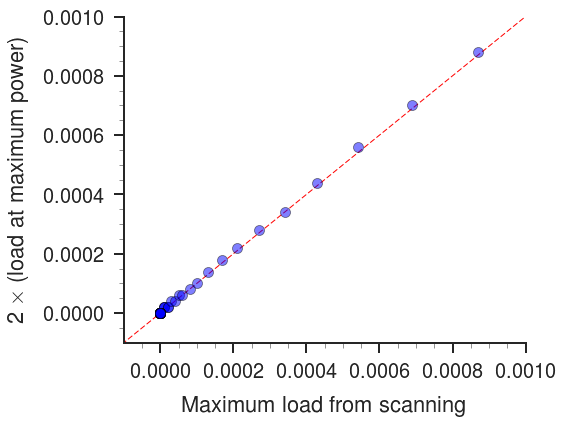

In [52]:
ax = generic_plot(df['Max load'], 2*df['Load @ max power'], 
                  xlabel='Maximum load from scanning',
                 ylabel=r'2 $\times$ (load at maximum power)')
from scipy.stats import linregress

ax.plot([-1, 1], [-1, 1], ls='--', lw=1, c='r', zorder=-1, label=r'$y = x$')
ax.set_ylim([-0.0001, 0.0010])
ax.set_xlim([-0.0001, 0.0010])
# ax.legend(frameon=True)

In [55]:
calculation = True
from tqdm import tqdm
df = pd.DataFrame()
if calculation:
    for concentration in tqdm(np.arange(-6, 0, 0.1)):
        for name in ['chi2THR175']:
            max_power, max_power_load, max_load = summarize_power_and_load(name, concentration=10**concentration, negative=True, 
                                                           debug=False, data_source='adk_md_data')
            df = df.append(pd.DataFrame({'Concentration': concentration,
                              
                                    'File': name,
                                    'Max power': max_power,
                                    'Load @ max power' : max_power_load,
                                    'Max load': max_load,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)


100%|██████████| 60/60 [00:30<00:00,  1.18s/it]


(-0.001, 0.0001)

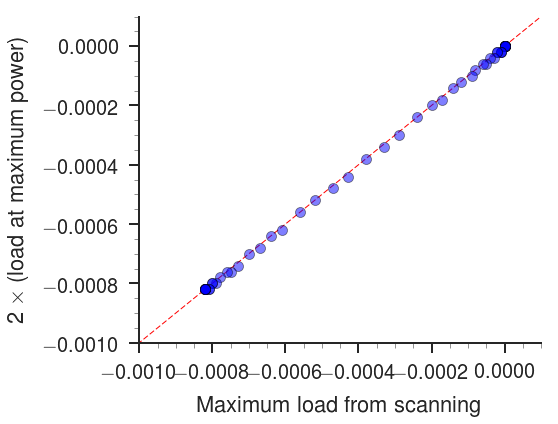

In [57]:
ax = generic_plot(df['Max load'], 2*df['Load @ max power'], 
                  xlabel='Maximum load from scanning',
                 ylabel=r'2 $\times$ (load at maximum power)')
from scipy.stats import linregress

ax.plot([-1, 1], [-1, 1], ls='--', lw=1, c='r', zorder=-1, label=r'$y = x$')
ax.set_ylim([-0.0010, 0.0001])
ax.set_xlim([-0.0010, 0.0001])
# ax.legend(frameon=True)